# Clasificación por medio de una feed-forward neural network
## Proyecto Final - Statistical Learning II

### Edgar Sabán 19012631

<img src="images/dataset-cover.png">

El conjunto de datos tiene como objetivo detectar si una persona está corriendo o caminando con base a los datos recopilados por los sensores del acelerómetro y giroscópio que posee un dispositivo iOS. Los datos fueron recopilados con el apoyo de el app "Data Collection", la cual fue desarrollada para este propósito.

Actualmente el conjunto de datos con 88,588 observaciones recolectadas desde el acelerómetro y giroscopio de un iPhone 5c en intervalos de 10 segundos con una frecuencia aproximada de 5.4 observaciones por segundo.

Los datos está representados por las siguientes columnas:

- acceleration_x
- acceleration_y
- acceleration_z
- gyro_x
- gyro_y
- gyro_z

Cada columna representa los datos del sensor en cada eje.

La columna "activity" representa la etiquetas y tiene los siguientes valores:
- "0": walking
- "1": running

Así mismo la columna "wrist" representa el lado donde el dispositivo estaba colocado al momento de recolectar los datos.
- "0": left wrist
- "1": right wrist

## Analizando los datos

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks")

from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
dataset = pd.read_csv("data/dataset_p1.csv")
dataset.head()

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-6-30,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-6-30,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-6-30,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-6-30,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-6-30,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


In [3]:
# verificando Nullos
dataset.isnull().sum()

date              0
time              0
username          0
wrist             0
activity          0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
dtype: int64

In [4]:
# Contados labels por actividad
walking = len(dataset[dataset["activity"] == 0].index)
running  = len(dataset[dataset["activity"] == 1].index)

print(f"Registros walking {walking}")
print(f"Registros running {running}")

Registros walking 44223
Registros running 44365


Se puede observar que los labels están balanceados.

In [5]:
left   = len(dataset[dataset["wrist"] == 0].index)
right  = len(dataset[dataset["wrist"] == 1].index)
print(f"Registros de lado izquierdo {left}")
print(f"Registros de lado derecho {right}")

Registros de lado izquierdo 42330
Registros de lado derecho 46258


De igual forma se puede observar que las observaciones para "wrist" están balanceadas.

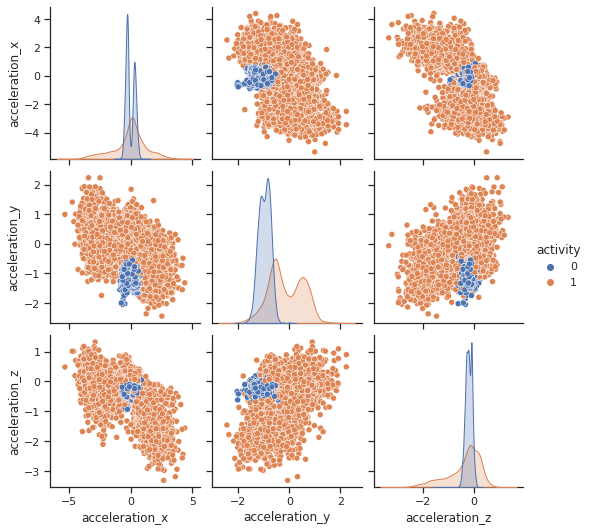

In [6]:
# Graficando la aceleración x, y y z clasificado por actividad
sns.pairplot(dataset[["acceleration_x", "acceleration_y", "acceleration_z", "activity"]].sample(frac=.2), hue="activity")

Con tres variables es un poco complejo interpretar los que sucede entre estas tres variables, por ello se procede a la reducción de dimensionalidad con el objetivo de poder observar el comportamiento de los componentes principales respecto a la actividad.

In [7]:
aceleracion = dataset[["acceleration_x", "acceleration_y", "acceleration_z", "wrist", "activity"]].sample(frac=.2).reset_index(drop=True)

tsne = manifold.TSNE(n_components = 2, random_state=42)
data_transformada = tsne.fit_transform(aceleracion[["acceleration_x", "acceleration_y", "acceleration_z", "wrist"]])

In [8]:
tsne_data = pd.DataFrame(np.column_stack((data_transformada, aceleracion["activity"])),
                    columns=["x", "y", "activity"])
tsne_data.loc[:, "activity"] = tsne_data.activity.astype(int)

/home/dsenv/anaconda3/envs/ds/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


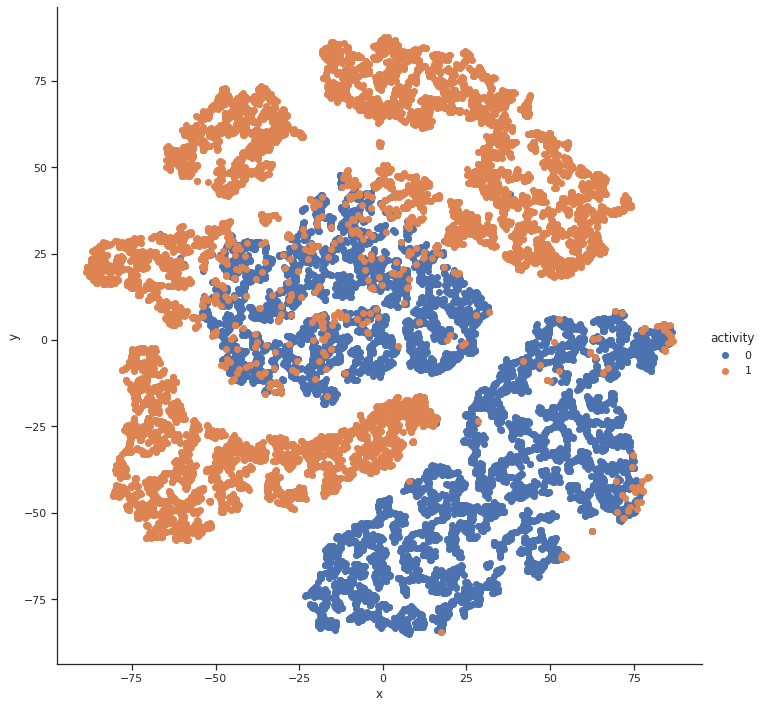

In [9]:
graph = sns.FacetGrid(tsne_data, hue="activity", size=10)
graph.map(plt.scatter, "x", "y").add_legend()

Se puede observar que sí existe cierta tendencia de agrupación de los datos cuanto la actividad es walking y running.

## Implementando feed-forward neural network

In [10]:
# obteniendo X y Y
X = np.array(dataset[["acceleration_x", "acceleration_y", "acceleration_z", "wrist", "gyro_x", "gyro_y", "gyro_z"]])
y = np.array(dataset["activity"])

In [11]:
# Train y Test
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (70870, 7) (70870,)
Testing data shape :  (17718, 7) (17718,)


In [27]:
# Definiendo arquitectura de la red
def crear_red():
    model = keras.Sequential(
    [
        layers.Dense(14, input_shape = (None,7), activation="relu"),
        layers.Dense(20, activation="relu"),
        layers.Dense(10, activation="relu"),
        layers.Dense(5, activation="relu"),
        layers.Dropout(0.25),
        layers.Dense(1,  activation="sigmoid"),
    ]
    )
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [28]:
model = crear_red()

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, None, 14)          112       
_________________________________________________________________
dense_11 (Dense)             (None, None, 20)          300       
_________________________________________________________________
dense_12 (Dense)             (None, None, 10)          210       
_________________________________________________________________
dense_13 (Dense)             (None, None, 5)           55        
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 5)           0         
_________________________________________________________________
dense_14 (Dense)             (None, None, 1)           6         
Total params: 683
Trainable params: 683
Non-trainable params: 0
________________________________________________________

In [30]:
history_model = model.fit(train_X, train_Y, batch_size=128, epochs=20, verbose=True, validation_split=.1)

Epoch 1/20
499/499 [==============================] - 2s 2ms/step - loss: 0.3343 - accuracy: 0.8562 - val_loss: 0.0713 - val_accuracy: 0.9798
Epoch 2/20
499/499 [==============================] - 1s 2ms/step - loss: 0.1144 - accuracy: 0.9791 - val_loss: 0.0477 - val_accuracy: 0.9849
Epoch 3/20
499/499 [==============================] - 1s 2ms/step - loss: 0.0841 - accuracy: 0.9853 - val_loss: 0.0370 - val_accuracy: 0.9886
Epoch 4/20
499/499 [==============================] - 1s 2ms/step - loss: 0.0708 - accuracy: 0.9867 - val_loss: 0.0360 - val_accuracy: 0.9886
Epoch 5/20
499/499 [==============================] - 1s 2ms/step - loss: 0.0629 - accuracy: 0.9871 - val_loss: 0.0359 - val_accuracy: 0.9887
Epoch 6/20
499/499 [==============================] - 1s 2ms/step - loss: 0.0550 - accuracy: 0.9875 - val_loss: 0.0350 - val_accuracy: 0.9883
Epoch 7/20
499/499 [==============================] - 1s 2ms/step - loss: 0.0533 - accuracy: 0.9875 - val_loss: 0.0350 - val_accuracy: 0.9891
Epoch 

In [31]:
loss, accuracy  = model.evaluate(test_X, test_Y, verbose=True)

554/554 [==============================] - 1s 947us/step - loss: 0.0266 - accuracy: 0.99290s - loss: 0.0262 - accuracy: 0.99


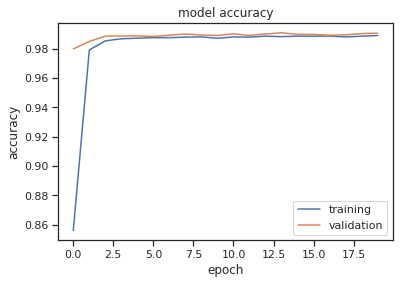

Test loss: 0.0266
Test accuracy: 0.993


In [32]:
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

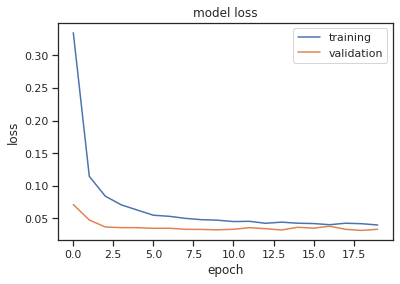

Test loss: 0.0266
Test accuracy: 0.993


In [33]:
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

### Predicciones

In [34]:
Y = model.predict(test_X)
Y = np.round(Y[:,0]).astype('int')

In [35]:
correct = Y == test_Y
correct.sum()

17593

In [36]:
incorrect = Y != test_Y
incorrect.sum()

125

In [38]:
print(classification_report(Y, test_Y))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8883
           1       0.99      0.99      0.99      8835

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718



Referencia:
https://www.kaggle.com/vmalyi/run-or-walk